# QAOA for random bond Ising model (RBIM)

In [35]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

import importlib
importlib.reload(qaoa)
importlib.reload(qucs)

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

##  0 Define the graph

In [2]:
# grid graph
n_nodes = 4
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

In [190]:
# grid graph
n_nodes = 9
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (0,3), (1, 2), (1, 4), (2, 5), (3,4), (3,6), (4, 5), (4, 7), (5,8), (6, 7), (7, 8)]

In [3]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

### 0.1 plot the graph

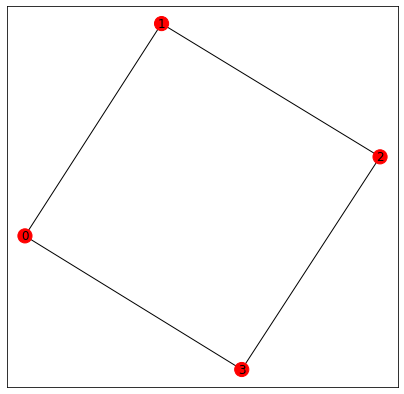

In [5]:
fig = plt.figure(figsize = (7,7))
colors = ['r' for node in graph.nodes()]
pos = nx.planar_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, pos = None, alpha=1, with_labels=True)
plt.show()

## 1 choose probability

$$H_{RBIM} = -\sum_{<i,j>}K_{ij}Z_iZ_j,$$

$P(K_{ij}) = p\delta(K_{ij}-K) + (1-p)\delta(K_{ij}+K) \; , K>0$

In [6]:
prob = 1 #prbability 0.5 < prob < 1 that the site is ferromagnetic (all 1 or -1), expect phase-transistion at p = 0.88

bin_prob_dist = np.random.binomial(1, prob, size=(len(edges),)) # 1 for ferromagnetic link

bin_prob_dist

array([1, 1, 1, 1])

In [7]:
for i, link in enumerate (bin_prob_dist):
    if link == 0:
        bin_prob_dist[i] = -1
bin_prob_dist

array([1, 1, 1, 1])

## 2 Define needed functions

In [8]:
def evaluate_energy_ising(list_z, edges, bin_prob_dist, coupling_const=1):
    energy = 0
    for i, edge in enumerate(edges):
        energy += -bin_prob_dist[i]*list_z[edge[0]]*list_z[edge[1]]
    return coupling_const*energy

In [62]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)
for outcome in all_outcomes:
    print(outcome, evaluate_energy_ising(outcome, edges, bin_prob_dist))

(1, 1, 1, 1) -4
(1, 1, 1, -1) 0
(1, 1, -1, 1) 0
(1, 1, -1, -1) 0
(1, -1, 1, 1) 0
(1, -1, 1, -1) 4
(1, -1, -1, 1) 0
(1, -1, -1, -1) 0
(-1, 1, 1, 1) 0
(-1, 1, 1, -1) 0
(-1, 1, -1, 1) 4
(-1, 1, -1, -1) 0
(-1, -1, 1, 1) 0
(-1, -1, 1, -1) 0
(-1, -1, -1, 1) 0
(-1, -1, -1, -1) -4


In [10]:
def evaluate_magnetization_ising(list_z):
    """This method evaluates the object function of the RBIM
    Parameters
        z_str : input bit string
        edges : edges of the graph
    Returns
        the integer value the object function"""

    return abs(sum(list_z))

In [11]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)
for outcome in all_outcomes:
    print(outcome, evaluate_magnetization_ising(outcome))

(1, 1, 1, 1) 4
(1, 1, 1, -1) 2
(1, 1, -1, 1) 2
(1, 1, -1, -1) 0
(1, -1, 1, 1) 2
(1, -1, 1, -1) 0
(1, -1, -1, 1) 0
(1, -1, -1, -1) 2
(-1, 1, 1, 1) 2
(-1, 1, 1, -1) 0
(-1, 1, -1, 1) 0
(-1, 1, -1, -1) 2
(-1, -1, 1, 1) 0
(-1, -1, 1, -1) 2
(-1, -1, -1, 1) 2
(-1, -1, -1, -1) 4


In [12]:
def prob_hamilt_ising(n_qubits, edges, bin_prob_dist, coupling_const=1):
    if n_qubits < 2:
        raise ValueError('number of qubits must be > 1, but is {}'.format(n_qubits))
    list_double_sigmaz = []
    for i, edge in enumerate(edges):
        list_double_sigmaz.append(
            qucs.n_sigmaz(n_qubits,edge[0])*qucs.n_sigmaz(n_qubits,edge[1])*bin_prob_dist[i]
            ) 
    return -sum(list_double_sigmaz)*coupling_const

In [13]:
def evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist):
    if len(gammas) < 1:
        raise ValueError('number of gammas must be > 0, but is {}'.format(len(gammas)))
    if len(betas) < 1:
        raise ValueError('number of gammas must be > 0, but is {}'.format(len(betas)))
    if len(betas) != len(gammas):
        raise ValueError('number of gammas must be = number of betas')
    if n_qubits < 2:
        raise ValueError('number of qubits must be > 1, but is {}'.format(n_qubits))
    evol_oper = qucs.n_qeye(n_qubits)
    for i in range(len(gammas)):
        u_mix_hamilt_i = (-complex(0,betas[i])*qaoa.mix_hamilt(n_qubits)).expm()
        #u_prob_hamilt_i = (-complex(0,gammas[i])*qaoa.prob_hamilt(n_qubits, edges)).expm()
        u_prob_hamilt_i = (-complex(0,gammas[i])*prob_hamilt_ising(n_qubits, edges, bin_prob_dist)).expm()
        evol_oper = u_mix_hamilt_i*u_prob_hamilt_i*evol_oper
    return evol_oper

In [14]:
def single_qubit_measurement_ising(qstate, qubit_pos):
    n_qubits = len(qstate.dims[0])
    if qstate.dims[1][0] == 1:
        qstate = qu.ket2dm(qstate)
    M_i = (qucs.n_proj0(n_qubits, qubit_pos)*qstate)
    p0_i = M_i.tr()
    #p1_i = (n_proj1(n_qubits, i)*dm_dummy).tr()
    if np.random.random_sample() <= p0_i:
        outcome = [1]
        qstate = M_i/p0_i
    else:
        outcome = [-1]
        qstate = (qucs.n_proj1(n_qubits, qubit_pos)*qstate)/(1-p0_i)
    return outcome, qstate

In [15]:
def quantum_measurements_ising(n_samples, qstate):
    n_qubits = len(qstate.dims[0])
    if qstate.dims[1][0] == 1:
        qstate = qu.ket2dm(qstate)
    outcomes = []
    for j in range(n_samples):
        outcome = []
        qstate_dummy = qstate.copy()
        for i in range(n_qubits):
            outcome_i, qstate_dummy = single_qubit_measurement_ising(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    return outcomes

In [16]:
def evaluate_energy_p(params, n_qubits, edges, bin_prob_dist, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    #fin_state = qaoa.evolution_operator(n_qubits, edges, gammas, betas)*init_state

    
    #Perform N measurements on each single qubit of final state
    outcomes = quantum_measurements_ising(n_samples, fin_state)
    dict_outcomes = {}
    for outcome in outcomes:
        dict_outcomes[tuple(outcome)] = outcomes.count(outcome)
    
    #Evaluate Fp
    Ep = 0
    for outcome_w in dict_outcomes:
        Ep += dict_outcomes[outcome_w]*evaluate_energy_ising(outcome_w, edges, bin_prob_dist)
    return Ep/n_samples

In [17]:
def evaluate_magnetization_p(params, n_qubits, edges, bin_prob_dist, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    
    #Perform N measurements on each single qubit of final state
    outcomes = quantum_measurements_ising(n_samples, fin_state)
    dict_outcomes = {}
    for outcome in outcomes:
        dict_outcomes[tuple(outcome)] = outcomes.count(outcome)
    
    #Evaluate Fp
    Mp = 0
    for outcome_w in dict_outcomes:
        Mp += dict_outcomes[outcome_w]*evaluate_magnetization_ising(outcome_w)
    return Mp/n_samples

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

the idea is that, for each ($\gamma,\beta$), after each measurement I will obtain as outcome one of the elements of the computational basis: $\{z : z \in \{ 0,1 \}^n\}$

so, after N measurements, I will have each that each possible outcome $z_i$ has been obtained with occurency $w_i$, so $F_p$ will be evaluated as:

$$F_p = \frac{\sum_{i}^{N}{w_iC(z_i)}}{\sum_{i}^{N}{w_i}}$$

### 1.5 Parameters update

In [34]:
#Adam
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_levels = 1
n_steps = 20
#parameters = np.array(0.5*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
parameters = 0.01*np.random.rand(2*n_levels)
"""
parameters = np.zeros(2*n_levels) # method used in the paper
for j in range(2*n_levels):
    if j%2 == 0: #for H-p parameters
        parameters[j] = j/(2*n_levels) #see SGD paper for reference
    else:
        parameters[j] = 1 - j/(2*n_levels) #see SDG paper
"""
init_state = qaoa.initial_state(n_qubits)
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
H_P = prob_hamilt_ising(n_qubits, edges, bin_prob_dist)
eta = 0.05 #works also for eta = 0.01, but increases very slowly, and 0.1 oscillates too much around max
previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_energy_p, parameters, args=(n_qubits, edges, bin_prob_dist, 100), increment=0.1)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    E_p_adam = qu.expect(H_P, fin_state)
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    #if (i + 1) % 1 == 0:
    print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, E_p_adam))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters - eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
optimal_gammas = optimal_parameters_Adam_fin_diff[:n_levels]
optimal_betas = optimal_parameters_Adam_fin_diff[n_levels:]
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_1 is', qu.expect(H_P, evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state))

in [0.00446982 0.0062028 ] with grad  [ 2. -2.] objective after step     1:  0.0008871
in [-0.04553018  0.0562028 ] with grad  [ 1.2 -2.4] objective after step     2: -0.0807494
in [-0.09269544  0.10649817] with grad  [ 2.4 -4. ] objective after step     3: -0.2994593
in [-0.14190116  0.15683654] with grad  [ 5.  -2.2] objective after step     4: -0.6311569
in [-0.19092928  0.20557713] with grad  [ 6.4 -2.8] objective after step     5: -1.0135127
in [-0.24151838  0.25475319] with grad  [ 3.2 -5.2] objective after step     6: -1.4011391
in [-0.29083783  0.30615404] with grad  [-0.6 -4.6] objective after step     7: -1.7273369
in [-0.32841177  0.358739  ] with grad  [ 1.4 -2. ] objective after step     8: -1.9164194
in [-0.3636212   0.40763709] with grad  [ 1.8 -1.2] objective after step     9: -1.9829417
in [-0.39830941  0.45154889] with grad  [-1.6  3.8] objective after step    10: -1.9443529
in [-0.4205021   0.47189797] with grad  [-1.2  2.2] objective after step    11: -1.8887366
in 

In [20]:
n_samples = 100
outcomes = quantum_measurements_ising(n_samples, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

In [27]:
max_occurrency = max(list(dict_outcomes.values()))

In [28]:
index_max_occurrency = list(dict_outcomes.values()).index(max_occurrency)

In [31]:
most_probable_state = list(dict_outcomes.keys())[index_max_occurrency]
most_probable_state

(1, 1, 1, 1)

In [33]:
M = evaluate_magnetization_ising(most_probable_state)
M

4

<BarContainer object of 16 artists>

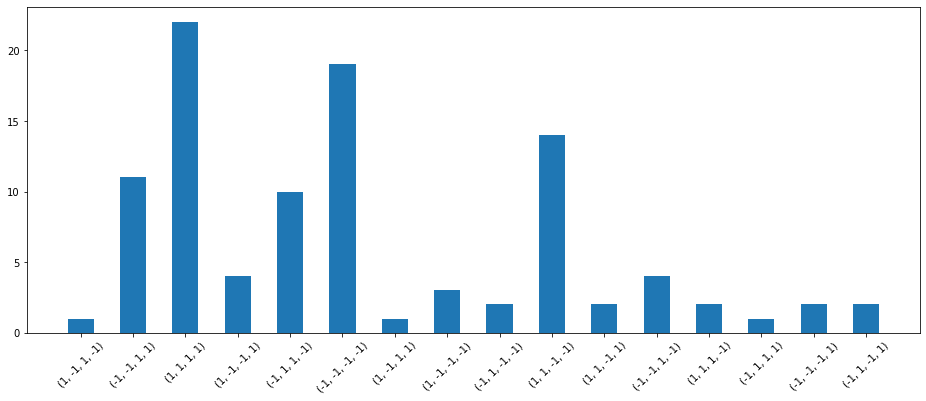

In [60]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits,6))
plt.xticks(rotation=45)
x_axis = []
for key in dict_outcomes:
    x_axis.append(str(key))
plt.bar(x_axis, dict_outcomes.values(), width = 0.5)

In [188]:
evaluate_energy_p(optimal_parameters_Adam_fin_diff, n_qubits, edges, bin_prob_dist, 100)

-2.08

In [189]:
evaluate_magnetization_p(optimal_parameters_Adam_fin_diff, n_qubits, edges, bin_prob_dist, 100)

1.9

In [36]:
# obtain final state:
#optimal_params = optimal_params_scipy
optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
#fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
fin_state = evolution_operator_ising(n_qubits, edges, optimal_gammas, optimal_betas, bin_prob_dist)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

In [37]:
prob_dist_fin_state = qucs.comp_basis_prob_dist(fin_state)

In [80]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)
for i in all_outcomes:
    print(str(list(i)))


[1, 1, 1, 1]
[1, 1, 1, -1]
[1, 1, -1, 1]
[1, 1, -1, -1]
[1, -1, 1, 1]
[1, -1, 1, -1]
[1, -1, -1, 1]
[1, -1, -1, -1]
[-1, 1, 1, 1]
[-1, 1, 1, -1]
[-1, 1, -1, 1]
[-1, 1, -1, -1]
[-1, -1, 1, 1]
[-1, -1, 1, -1]
[-1, -1, -1, 1]
[-1, -1, -1, -1]


In [57]:
all_outcomes

TypeError: 'itertools.product' object is not subscriptable

In [105]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)
xtick_labels = []
for outcome in all_outcomes:
    xtick_labels.append(str(list(outcome)))    
xtick_labels

['[1, 1, 1, 1]',
 '[1, 1, 1, -1]',
 '[1, 1, -1, 1]',
 '[1, 1, -1, -1]',
 '[1, -1, 1, 1]',
 '[1, -1, 1, -1]',
 '[1, -1, -1, 1]',
 '[1, -1, -1, -1]',
 '[-1, 1, 1, 1]',
 '[-1, 1, 1, -1]',
 '[-1, 1, -1, 1]',
 '[-1, 1, -1, -1]',
 '[-1, -1, 1, 1]',
 '[-1, -1, 1, -1]',
 '[-1, -1, -1, 1]',
 '[-1, -1, -1, -1]']

In [97]:
type(xtick_labels)

list

In [85]:
x_axis = np.array(xtick_labels)
x_axis.shape

(16,)

In [86]:
x_axis

array(['-1, -1, -1, -1', '-1, -1, -1, -1', '-1, -1, -1, -1',
       '-1, -1, -1, -1', '-1, -1, -1, -1', '-1, -1, -1, -1',
       '-1, -1, -1, -1', '-1, -1, -1, -1', '-1, -1, -1, -1',
       '-1, -1, -1, -1', '-1, -1, -1, -1', '-1, -1, -1, -1',
       '-1, -1, -1, -1', '-1, -1, -1, -1', '-1, -1, -1, -1',
       '-1, -1, -1, -1'], dtype='<U14')

In [93]:
xticks = range(0,2**(n_qubits))
xtick_labels = list(map(lambda x: format(x, xtick_labels), xticks))

TypeError: format() argument 2 must be str, not list

In [99]:
prob_dist_fin_state

[0.2569669918945841,
 0.01828303438402278,
 0.018283034384022793,
 0.08000564131073587,
 0.01828303438402278,
 0.009889587947852477,
 0.08000564131073584,
 0.018283034384022793,
 0.018283034384022786,
 0.08000564131073584,
 0.009889587947852477,
 0.018283034384022772,
 0.08000564131073581,
 0.018283034384022786,
 0.018283034384022786,
 0.2569669918945842]

In [106]:
dict_prob = {}
for i, label in enumerate(xtick_labels):
    print(i, label)
    dict_prob[label] = prob_dist_fin_state[i]

0 [1, 1, 1, 1]
1 [1, 1, 1, -1]
2 [1, 1, -1, 1]
3 [1, 1, -1, -1]
4 [1, -1, 1, 1]
5 [1, -1, 1, -1]
6 [1, -1, -1, 1]
7 [1, -1, -1, -1]
8 [-1, 1, 1, 1]
9 [-1, 1, 1, -1]
10 [-1, 1, -1, 1]
11 [-1, 1, -1, -1]
12 [-1, -1, 1, 1]
13 [-1, -1, 1, -1]
14 [-1, -1, -1, 1]
15 [-1, -1, -1, -1]


In [102]:
dict_prob

{'-1, -1, -1, -1': 0.2569669918945842}

<BarContainer object of 16 artists>

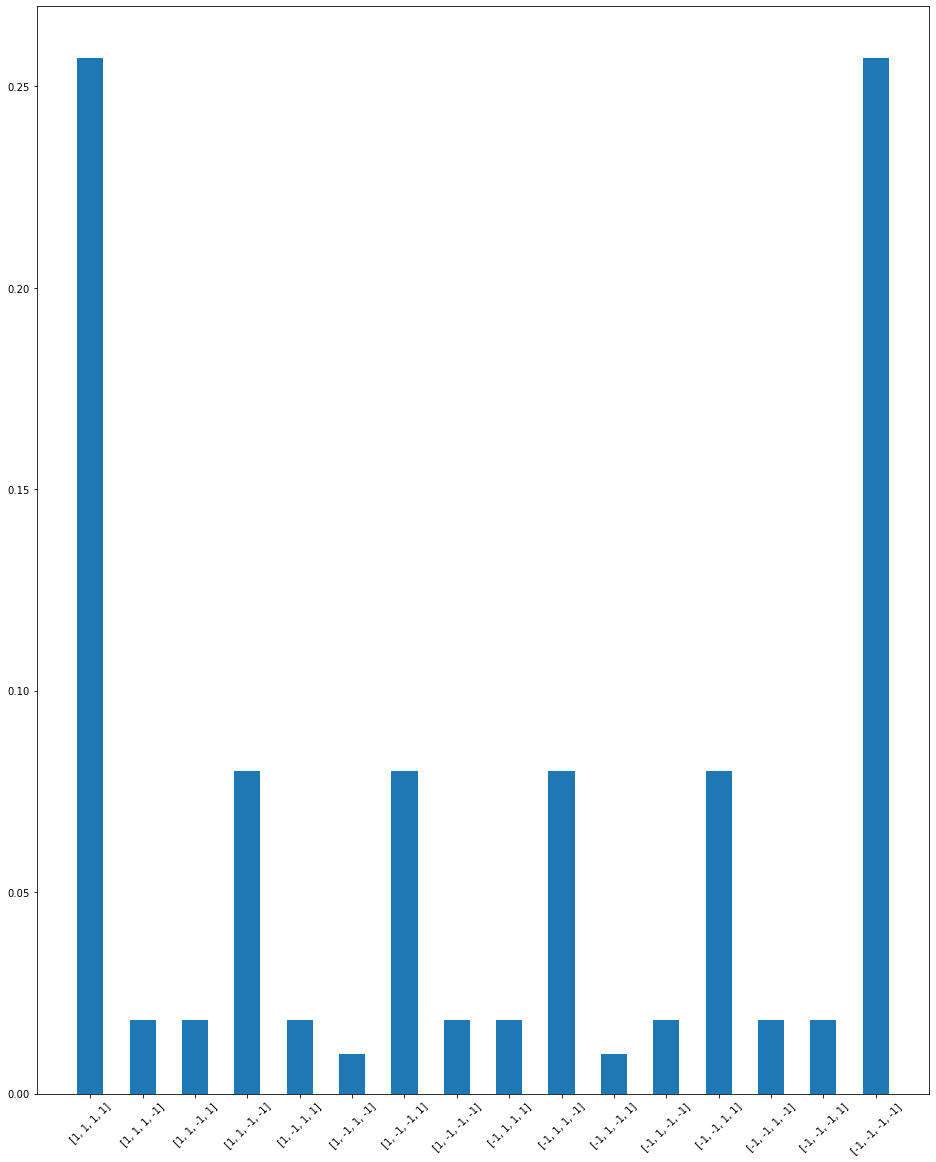

In [107]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut (using the state)
plt.figure(figsize = (2**n_qubits,20))
plt.xticks(rotation=45)
xticks = range(0,2**(n_qubits-1))
plt.bar(xtick_labels,prob_dist_fin_state,width = 0.5)

<BarContainer object of 15 artists>

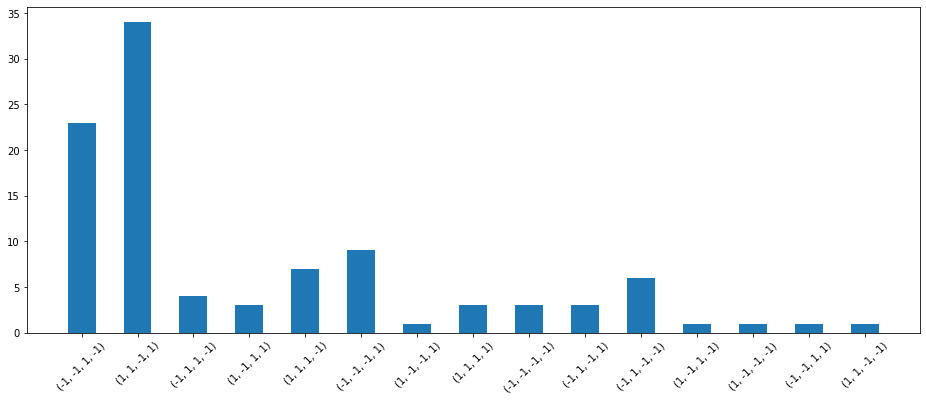

In [187]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits,6))
plt.xticks(rotation=45)
x_axis = []
for key in dict_outcomes:
    x_axis.append(str(key))
plt.bar(x_axis, dict_outcomes.values(), width = 0.5)

## Evaluate E and M for different prob

In [133]:
probabilities = np.arange(1, 0.84, -0.02)
probabilities

array([1.  , 0.98, 0.96, 0.94, 0.92, 0.9 , 0.88, 0.86, 0.84])

In [132]:
n_levels = 1
n_steps = 20
eta = 0.05
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-8
N = 10
prob_E_M = []
n_steps = 20

for prob in probabilities:
    energies = []
    magnetizations = []
    for i in range(N):
        
        #define bin_prob_dist
        bin_prob_dist = np.random.binomial(1, prob, size=(len(edges),))
        for i, link in enumerate (bin_prob_dist):
            if link == 0:
                bin_prob_dist[i] = -1
                
        #Adam
        parameters = 0.01*np.random.rand(2*n_levels)
        m_t = np.zeros(2*n_levels)
        v_t = np.zeros(2*n_levels)
        t = 0
        for i in range(n_steps):
            g_t = qaoa.fin_diff_grad(evaluate_energy_p, parameters, args=(n_qubits, edges, bin_prob_dist, 100), increment=0.1)
            t = t+1
            m_t = beta_1*m_t + (1-beta_1)*g_t
            v_t = beta_2*v_t + (1-beta_2)*g_t**2
            m_t_hat = m_t/(1-beta_1**t)
            v_t_hat = v_t/(1-beta_2**t)
            parameters = parameters - eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
        
        #evalute estimations of energy and magnetization
        energy = evaluate_energy_p(parameters, n_qubits, edges, bin_prob_dist, 1000)
        energies.append(energy)
        magnetization = evaluate_magnetization_p(parameters, n_qubits, edges, bin_prob_dist, 1000)
        magnetizations.append(magnetization)
        
    #store results in a list
    mean_en = sum(energies)/N
    mean_mag = sum(magnetizations)/N
    prob_E_M.append([prob, mean_en, mean_mag])

#store result in a file
np.savetxt('Ising_4nodes_prob_en_mag', prob_E_M)

0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.9600000000000001
0.9800000000000001
1.0


In [158]:
results = np.loadtxt('Ising_4nodes_prob_en_mag.txt')

In [159]:
results

array([[ 0.8   , -1.9016,  1.9212],
       [ 0.82  , -1.8284,  2.19  ],
       [ 0.84  , -1.8532,  1.9516],
       [ 0.86  , -1.8484,  2.102 ],
       [ 0.88  , -1.844 ,  2.1342],
       [ 0.9   , -1.6944,  2.1246],
       [ 0.92  , -1.9292,  2.224 ],
       [ 0.94  , -1.878 ,  2.3348],
       [ 0.96  , -1.804 ,  2.277 ],
       [ 0.98  , -1.7688,  2.264 ]])

In [ ]:
results = np.load('')